# Evaluation

In [1]:
import sys
import os
import glob
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.manifold import TSNE
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# Add parent directory to path to import your modules
sys.path.append("..") 

# Import your model definition (Ensure train_gait_model.py is in the parent/train folder)
from ttv.train_gait_model import SiameseFusion, SixStreamGaitDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


In [2]:
# Configuration
# Use this when converted to a script
# BASE_DIR = Path(__file__).resolve().parent
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "processed_tensors"
MODEL_PATH = BASE_DIR.parent / "ttv" / "best_gait_model-t_tgm-251211-2011.pth"
TEST_SUBJ_FILE = BASE_DIR.parent / "test_subjects.txt"

### loading the dataset

In [ ]:
def load_test_data(data_dir, subject_list_path=None):
    # 1. Load all files
    all_files = glob.glob(data_dir / "*.pt")
    subject_ids = [os.path.basename(f).split('.')[0] for f in all_files]
    
    # 2. Determine Test Subjects
    if os.path.exists(subject_list_path):
        print(f"Loading test split from {subject_list_path}...")
        with open(subject_list_path, "r") as f:
            test_ids = [line.strip() for line in f.readlines()]
    else:
        print("WARNING: 'test_subjects.txt' not found. Re-calculating split using Seed 42...")
        np.random.seed(42)
        np.random.shuffle(subject_ids)
        # Re-creating the exact 70/15/15 split math
        n_total = len(subject_ids)
        n_train = int(n_total * 0.70)
        n_val = int(n_total * 0.15)
        test_ids = subject_ids[n_train + n_val:] # The last 15%
        
    print(f"Target Test Subjects ({len(test_ids)}): {test_ids}")
    
    # 3. Load actual tensors
    test_data = {}
    for sid in tqdm(test_ids, desc="Loading Test Tensors"):
        path = os.path.join(data_dir, f"{sid}.pt")
        if os.path.exists(path):
            test_data[sid] = torch.load(path)
        else:
            print(f"Missing file: {path}")
            
    return test_data, test_ids


In [5]:

# Run it
test_data_dict, test_subject_ids = load_test_data(DATA_DIR, TEST_SUBJ_FILE)
test_ds = SixStreamGaitDataset(test_data_dict, window_size=200, stride=50, mode='test')
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

NameError: name 'os' is not defined

In [9]:
# Load Model
model = SiameseFusion().to(device)
checkpoint = torch.load(MODEL_PATH)
# Handle if you saved a dict or just weights
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)
model.eval()

# Extract Features
embeddings = []
labels = []

print("Generating Embeddings...")
with torch.no_grad():
    for batch, subjs in tqdm(test_loader):
        # Move inputs to GPU
        for k in batch.keys():
            batch[k] = batch[k].to(device)
            
        # Forward pass (Get 64-dim vector)
        emb = model.backbone(batch)
        
        embeddings.append(emb.cpu().numpy())
        labels.extend(subjs)

embeddings = np.concatenate(embeddings)
labels = np.array(labels)
print(f"Extracted {embeddings.shape} matrix.")

Generating Embeddings...


  0%|          | 0/3630 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### older code

In [12]:
import glob
import os
import numpy as np
import torch
from tqdm.notebook import tqdm

# --- CONFIGURATION ---
DATA_DIR = "../processed_tensors"  # Check this path matches your folder structure
SEED = 42  # CRITICAL: Must match 'NUMBER_OF_LIFE' from training

def get_test_split_robust(data_dir):
    # 1. Find all subject files
    all_files = sorted(glob.glob(os.path.join(data_dir, "*.pt")))
    subject_ids = [os.path.basename(f).split('.')[0] for f in all_files]
    
    if len(subject_ids) == 0:
        raise ValueError(f"No .pt files found in {data_dir}. Check your path!")

    # 2. REPLICATE TRAINING LOGIC EXACTLY
    # We re-run the shuffle with the same seed to see where the split happened
    np.random.seed(SEED)
    np.random.shuffle(subject_ids)
    
    n_total = len(subject_ids)
    n_train = int(n_total * 0.70)
    n_val = int(n_total * 0.15)
    
    # The test set is whatever was left over
    test_ids = subject_ids[n_train + n_val:]
    
    print(f"Total Subjects: {n_total}")
    print(f"Reconstructed Test Set ({len(test_ids)} subjects):")
    print(test_ids)
    
    return test_ids

# Run it
test_subject_ids = get_test_split_robust(DATA_DIR)

# 3. Load the actual data for these subjects
test_data_dict = {}
for sid in tqdm(test_subject_ids, desc="Loading Data"):
    path = os.path.join(DATA_DIR, f"{sid}.pt")
    test_data_dict[sid] = torch.load(path)

print("Data loaded successfully.")

Total Subjects: 84
Reconstructed Test Set (14 subjects):
['S044', 'S035', 'S002', 'S082', 'S026', 'S003', 'S028', 'S178', 'S173', 'S025', 'S099', 'S150', 'S017', 'S080']


Loading Data:   0%|          | 0/14 [00:00<?, ?it/s]

Data loaded successfully.


In [13]:
from torch.utils.data import DataLoader
from sklearn.preprocessing import normalize

# 1. Setup the Dataset and Loader
# We use the 'test_data_dict' created in the previous Robust Split cell
# Ensure 'SixStreamGaitDataset' is imported from your train_gait_model.py
test_ds = SixStreamGaitDataset(test_data_dict, window_size=200, stride=50, mode='test')
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0)

# 2. Extraction Loop
embeddings = []
labels = []

print(f"Generating embeddings for {len(test_ds)} samples...")
model.eval()

with torch.no_grad():
    for batch, subjs in tqdm(test_loader, desc="Extracting Features"):
        # Move data to GPU
        for k in batch.keys():
            batch[k] = batch[k].to(device)
            
        # Forward Pass
        # Note: We use model.backbone() to get the vector, not model() which gives triplets
        emb = model.backbone(batch)
        
        embeddings.append(emb.cpu().numpy())
        labels.extend(subjs)

# 3. Concatenate and Normalize
embeddings = np.concatenate(embeddings)
labels = np.array(labels)

print("Normalizing embeddings (forcing Cosine Similarity)...")
embeddings = normalize(embeddings, norm='l2')

print(f"Extraction Complete. Shape: {embeddings.shape}")

Generating embeddings for 232278 samples...


Extracting Features:   0%|          | 0/3630 [00:00<?, ?it/s]

Normalizing embeddings (forcing Cosine Similarity)...
Extraction Complete. Shape: (232278, 64)


In [14]:
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import gc

def compute_verification_scores_balanced(embeddings, labels, block_size=1000):
    """
    Memory-Safe Verification.
    Downsamples BOTH Genuine and Imposter pairs to prevent RAM crashes.
    """
    # 1. Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    
    print("Encoding labels...")
    le = LabelEncoder()
    labels_int = le.fit_transform(labels)
    
    print(f"Moving {len(embeddings)} embeddings to GPU...")
    # Float32 is sufficient and saves memory
    emb_tensor = torch.tensor(embeddings, dtype=torch.float32, device=device)
    lbl_tensor = torch.tensor(labels_int, device=device)
    
    genuine_chunks = []
    imposter_chunks = []
    
    n_samples = len(emb_tensor)
    
    # 2. Define Sampling Rates
    # We want ~50 million pairs of each for a great ROC curve without crashing RAM
    # Genuine Total ~3.8 Billion -> Keep 1% -> 38 Million
    GENUINE_RATE = 0.01 
    # Imposter Total ~50 Billion -> Keep 0.1% -> 50 Million
    IMPOSTER_RATE = 0.001
    
    print(f"Processing {n_samples} samples (Gen Rate: {GENUINE_RATE}, Imp Rate: {IMPOSTER_RATE})...")

    with torch.no_grad():
        for i in tqdm(range(0, n_samples, block_size), desc="Scoring Blocks"):
            end_i = min(i + block_size, n_samples)
            
            # Create Query Block
            query_emb = emb_tensor[i:end_i]
            query_lbl = lbl_tensor[i:end_i]
            
            # Calculate Distance Matrix [BlockSize x TotalSamples]
            dists = torch.cdist(query_emb, emb_tensor, p=2)
            
            # Identify Matches [BlockSize x TotalSamples]
            # Broadcasting: (B, 1) == (1, N)
            is_match = (query_lbl.unsqueeze(1) == lbl_tensor.unsqueeze(0))
            
            # Generate Random Probability Matrix for Downsampling
            # This determines which pairs we keep
            probs = torch.rand_like(dists)
            
            # --- EXTRACT GENUINE ---
            # Keep if (Match) AND (Random < 1%) AND (Not Self)
            # dist > 1e-5 removes distance to self (0.0)
            gen_mask = is_match & (probs < GENUINE_RATE) & (dists > 1e-5)
            genuine_chunks.append(dists[gen_mask].cpu().numpy())
            
            # --- EXTRACT IMPOSTER ---
            # Keep if (Not Match) AND (Random < 0.1%)
            imp_mask = (~is_match) & (probs < IMPOSTER_RATE)
            imposter_chunks.append(dists[imp_mask].cpu().numpy())
            
            # Cleanup VRAM
            del dists, is_match, probs, gen_mask, imp_mask
            
    # 3. Merge Results
    print("Merging chunks...")
    if genuine_chunks:
        genuine_scores = np.concatenate(genuine_chunks)
    else:
        genuine_scores = np.array([])
        
    if imposter_chunks:
        imposter_scores = np.concatenate(imposter_chunks)
    else:
        imposter_scores = np.array([])

    # Cleanup GPU memory
    del emb_tensor, lbl_tensor
    torch.cuda.empty_cache()
    gc.collect()
    
    return genuine_scores, imposter_scores

# --- EXECUTION ---
if 'embeddings' in locals():
    gen_scores, imp_scores = compute_verification_scores_balanced(embeddings, labels)

    print(f"\nFINAL STATS:")
    print(f"Genuine Pairs:  {len(gen_scores):,} (from ~3.8 Billion)")
    print(f"Imposter Pairs: {len(imp_scores):,} (from ~50 Billion)")
else:
    print("ERROR: Please run the Feature Extraction cell first!")

Device: cuda
Encoding labels...
Moving 232278 embeddings to GPU...
Processing 232278 samples (Gen Rate: 0.01, Imp Rate: 0.001)...


Scoring Blocks:   0%|          | 0/233 [00:00<?, ?it/s]

Merging chunks...

FINAL STATS:
Genuine Pairs:  39,241,654 (from ~3.8 Billion)
Imposter Pairs: 50,032,692 (from ~50 Billion)


Calculating ROC & EER...

FINAL EER (Equal Error Rate): 6.66%
Optimal Distance Threshold: 0.1758


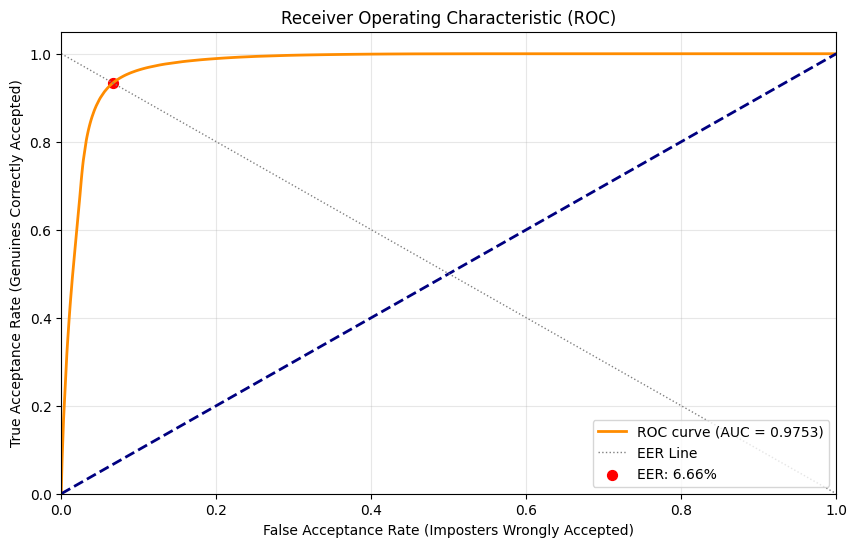

In [15]:
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d
from scipy.optimize import brentq
import matplotlib.pyplot as plt

print("Calculating ROC & EER...")

# 1. Prepare Data for Scikit-Learn
# Label 1 = Imposter (High Distance), Label 0 = Genuine (Low Distance)
# In verification, we usually want "True Positive" to mean "Genuine Accepted".
# So: Label 1 (Positive Class) = Genuine, Label 0 (Negative Class) = Imposter.
# BUT: Euclidean Distance is "Lower is Better".
# So we use -distance as the score. Higher (less negative) = Better Match.

y_true = np.concatenate([np.ones(len(gen_scores)), np.zeros(len(imp_scores))])
y_scores = np.concatenate([-gen_scores, -imp_scores]) # Negate distances so smaller = better

# 2. Calculate ROC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# 3. Calculate EER (Equal Error Rate)
# EER is where False Positive Rate (FPR) = False Rejection Rate (1 - TPR)
try:
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    # Recover the threshold (distance) that gives this EER
    # We negate it back to get the positive euclidean distance
    optimal_threshold = -interp1d(fpr, thresholds)(eer)
except Exception as e:
    print(f"Brentq failed ({e}), using approximation...")
    eer_idx = np.nanargmin(np.abs(fpr - (1 - tpr)))
    eer = fpr[eer_idx]
    optimal_threshold = -thresholds[eer_idx]

print(f"\n==========================================")
print(f"FINAL EER (Equal Error Rate): {eer*100:.2f}%")
print(f"Optimal Distance Threshold: {optimal_threshold:.4f}")
print(f"==========================================")

# 4. Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot([0, 1], [1, 0], color='gray', lw=1, linestyle=':', label='EER Line')
plt.scatter([eer], [1-eer], c='red', s=50, label=f'EER: {eer*100:.2f}%')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Acceptance Rate (Imposters Wrongly Accepted)')
plt.ylabel('True Acceptance Rate (Genuines Correctly Accepted)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

--- CONFUSION MATRIX (At Threshold 0.1758) ---
Genuine Samples: 39,241,654
Imposter Samples: 50,032,692
--------------------------------------------------
True Accepts  (Happy Users):   36,630,071 (93.34%)
False Rejects (Annoyed Users): 2,611,583  (6.66%)  <-- FRR
--------------------------------------------------
True Rejects  (Blocked Intruders): 46,702,957 (93.34%)
False Accepts (Security Breaches): 3,329,735  (6.66%)  <-- FAR
--------------------------------------------------


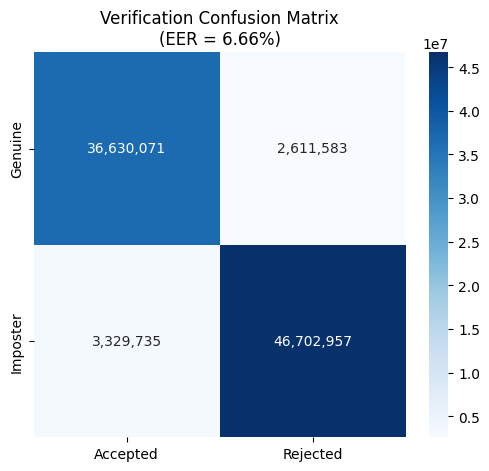

In [16]:
import seaborn as sns

# Calculate Binary Classifications based on the optimal threshold
# Genuine Scores < Threshold = Correct Accept (True Positive)
tp_count = np.sum(gen_scores < optimal_threshold)
fn_count = np.sum(gen_scores >= optimal_threshold) # False Rejects

# Imposter Scores > Threshold = Correct Reject (True Negative)
fp_count = np.sum(imp_scores < optimal_threshold) # False Accepts
tn_count = np.sum(imp_scores >= optimal_threshold)

# Calculate Percentages
far = fp_count / len(imp_scores) * 100 # False Accept Rate
frr = fn_count / len(gen_scores) * 100 # False Reject Rate

print(f"--- CONFUSION MATRIX (At Threshold {optimal_threshold:.4f}) ---")
print(f"Genuine Samples: {len(gen_scores):,}")
print(f"Imposter Samples: {len(imp_scores):,}")
print(f"--------------------------------------------------")
print(f"True Accepts  (Happy Users):   {tp_count:<10,} ({tp_count/len(gen_scores)*100:.2f}%)")
print(f"False Rejects (Annoyed Users): {fn_count:<10,} ({frr:.2f}%)  <-- FRR")
print(f"--------------------------------------------------")
print(f"True Rejects  (Blocked Intruders): {tn_count:<10,} ({tn_count/len(imp_scores)*100:.2f}%)")
print(f"False Accepts (Security Breaches): {fp_count:<10,} ({far:.2f}%)  <-- FAR")
print(f"--------------------------------------------------")

# Visual Heatmap
matrix = np.array([[tp_count, fn_count], [fp_count, tn_count]])
labels = ['Genuine', 'Imposter']
plt.figure(figsize=(6, 5))
sns.heatmap(matrix, annot=True, fmt=",d", cmap="Blues", 
            xticklabels=['Accepted', 'Rejected'], 
            yticklabels=['Genuine', 'Imposter'])
plt.title(f"Verification Confusion Matrix\n(EER = {eer*100:.2f}%)")
plt.show()

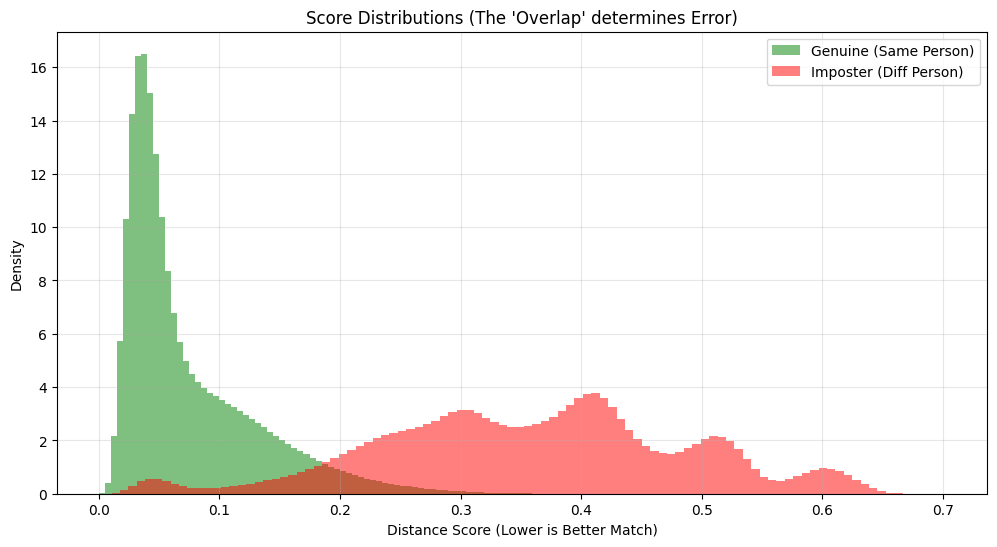

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_score_distributions(gen_scores, imp_scores):
    plt.figure(figsize=(12, 6))
    
    # Plot histograms (density=True normalizes them so they fit on same graph)
    plt.hist(gen_scores, bins=100, density=True, alpha=0.5, color='green', label='Genuine (Same Person)')
    plt.hist(imp_scores, bins=100, density=True, alpha=0.5, color='red', label='Imposter (Diff Person)')
    
    plt.title("Score Distributions (The 'Overlap' determines Error)")
    plt.xlabel("Distance Score (Lower is Better Match)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run it
plot_score_distributions(gen_scores, imp_scores)

In [11]:
import numpy as np
import torch

# 1. Inspect current state
print(f"Current embeddings type: {type(embeddings)}")
if isinstance(embeddings, list):
    print(f"List length: {len(embeddings)}")
    if len(embeddings) > 0:
        print(f"First element shape: {embeddings[0].shape}")
elif isinstance(embeddings, np.ndarray):
    print(f"Array shape: {embeddings.shape}")
elif isinstance(embeddings, torch.Tensor):
    print(f"Tensor shape: {embeddings.shape}")

# 2. Fix the shape
try:
    # If it's a list, concatenate it
    if isinstance(embeddings, list):
        print("Detected list. Concatenating...")
        embeddings = np.concatenate(embeddings)

    # If it's a 3D array/tensor (Batch, Seq, Feat), flatten it to 2D (Total, Feat)
    if len(embeddings.shape) == 3:
        print("Detected 3D structure. Flattening to 2D...")
        # Shape becomes (N * M, D)
        embeddings = embeddings.reshape(-1, embeddings.shape[-1])
        
    print(f"FIXED embeddings shape: {embeddings.shape}")
    
    # 3. Fix labels if needed (ensure it matches embeddings length)
    if len(labels) != len(embeddings):
        print(f"Warning: Label count ({len(labels)}) != Embedding count ({len(embeddings)})")
        # Usually labels are just a flat list, so this might be fine, 
        # but if labels is also a list of batches, flatten it:
        if isinstance(labels, list) and isinstance(labels[0], (list, np.ndarray)):
             labels = np.concatenate(labels)
             print(f"Fixed labels shape: {labels.shape}")

except Exception as e:
    print(f"Error during fix: {e}")

Current embeddings type: <class 'list'>
List length: 989
First element shape: (64, 64)
Detected list. Concatenating...
FIXED embeddings shape: (63296, 64)


In [ ]:

# --- EXECUTION ---
if 'embeddings' in locals():
    gen_scores, imp_scores = compute_verification_scores_balanced(embeddings, labels)

    print(f"\nFINAL STATS:")
    print(f"Genuine Pairs:  {len(gen_scores):,} (from ~3.8 Billion)")
    print(f"Imposter Pairs: {len(imp_scores):,} (from ~50 Billion)")
else:
    print("ERROR: Please run the Feature Extraction cell first!")

### eval + visual

#### Not weoking

In [ ]:
from scipy.spatial.distance import cdist

def compute_verification_scores(embeddings, labels, block_size=1000):
    genuine_scores = []
    imposter_scores = []
    
    n_samples = len(embeddings)
    print(f"Computing pairwise distances for {n_samples} samples...")
    print(f"Block size: {block_size} (Adjust if Memory/RAM fills up)")
    
    # Process in blocks to save RAM
    for i in tqdm(range(0, n_samples, block_size), desc="Comparing Blocks"):
        end_i = min(i + block_size, n_samples)
        chunk_emb = embeddings[i:end_i]
        chunk_lbl = labels[i:end_i]
        
        # Calculate distances between this block and ALL embeddings
        # metric='euclidean' on normalized data = Cosine Distance behavior
        dists = cdist(chunk_emb, embeddings, metric='euclidean')
        
        # Create boolean mask for Same Identity (Genuine)
        # We need to broadcast the labels to match the distance matrix shape
        match_mask = (chunk_lbl[:, None] == labels[None, :])
        
        # Extract Genuine Scores (Same Identity)
        # We filter out the diagonal (distance to self is always 0)
        # The mask [:, i:end_i] corresponds to the self-block
        
        # 1. Genuine Distances
        gen_dists = dists[match_mask]
        # Remove "Self" matches (distance ~ 0.0)
        gen_dists = gen_dists[gen_dists > 1e-6] 
        genuine_scores.extend(gen_dists)
        
        # 2. Imposter Distances
        imp_dists = dists[~match_mask]
        
        # Downsample Imposters to keep RAM usage sanity
        # (There are N^2 imposters, we don't need all 3 Billion)
        if len(imp_dists) > 0:
            # Randomly keep 1% of imposters, which is statistically sufficient
            # Increase this percentage if you have a lot of RAM (e.g. 0.05 or 0.10)
            np.random.seed(42 + i) # Deterministic randomness
            keep_mask = np.random.rand(len(imp_dists)) < 0.01 
            imposter_scores.extend(imp_dists[keep_mask])
            
    return np.array(genuine_scores), np.array(imposter_scores)

# Run the calculation
gen_scores, imp_scores = compute_verification_scores(embeddings, labels)
print(f"Genuine Pairs: {len(gen_scores):,}")
print(f"Imposter Pairs: {len(imp_scores):,}")

Computing pairwise distances for 232278 samples...
Block size: 1000 (Adjust if Memory/RAM fills up)


Comparing Blocks:   0%|          | 0/233 [00:00<?, ?it/s]

In [ ]:
import torch
from sklearn.preprocessing import LabelEncoder

def compute_verification_scores_gpu(embeddings, labels, block_size=2000):
    # --- FIX START: Encode String Labels to Integers ---
    print("Encoding labels to integers for GPU...")
    encoder = LabelEncoder()
    labels_int = encoder.fit_transform(labels)
    # ---------------------------------------------------

    # 1. Move everything to GPU
    print(f"Moving {len(embeddings)} embeddings to GPU...")
    
    # Convert Embeddings
    if isinstance(embeddings, np.ndarray):
        emb_tensor = torch.from_numpy(embeddings).float().to(device)
    else:
        emb_tensor = embeddings.to(device)
        
    # Convert Labels (Now using the Integer version)
    lbl_tensor = torch.tensor(labels_int).to(device)
    
    genuine_scores = []
    imposter_scores = []
    
    n_samples = len(emb_tensor)
    print(f"Computing pairwise distances on {device}...")
    
    # 2. Process in Blocks
    # Using 'desc' for progress bar
    for i in tqdm(range(0, n_samples, block_size), desc="Comparing Blocks (GPU)"):
        end_i = min(i + block_size, n_samples)
        
        # Slice the block (Query)
        block_emb = emb_tensor[i:end_i]      # Shape: [Block, 64]
        block_lbl = lbl_tensor[i:end_i]      # Shape: [Block]
        
        # Calculate Distances (Matrix vs Matrix)
        dists = torch.cdist(block_emb, emb_tensor, p=2) # Shape: [Block, N]
        
        # Create Boolean Mask for Genuine (Same Identity)
        # Compare [Block, 1] vs [1, N]
        match_mask = (block_lbl.unsqueeze(1) == lbl_tensor.unsqueeze(0))
        
        # 3. Extract Scores
        # Genuine: Select matches
        gen_dists = dists[match_mask]
        # Filter out self-loops (distance approx 0.0)
        gen_dists = gen_dists[gen_dists > 1e-5]
        genuine_scores.extend(gen_dists.cpu().numpy())
        
        # Imposter: Select non-matches
        # Random downsampling ON GPU
        random_filter = torch.rand_like(dists) < 0.01
        
        final_imp_mask = (~match_mask) & random_filter
        
        imp_dists = dists[final_imp_mask]
        imposter_scores.extend(imp_dists.cpu().numpy())
        
        # Cleanup
        del dists, match_mask, final_imp_mask, gen_dists, imp_dists
        
    return np.array(genuine_scores), np.array(imposter_scores)

# Run the fixed function
gen_scores, imp_scores = compute_verification_scores_gpu(embeddings, labels)

print(f"Genuine Pairs: {len(gen_scores):,}")
print(f"Imposter Pairs: {len(imp_scores):,}")

Encoding labels to integers for GPU...
Moving 232278 embeddings to GPU...
Computing pairwise distances on cuda...


Comparing Blocks (GPU):   0%|          | 0/117 [00:00<?, ?it/s]

In [ ]:
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

def compute_verification_scores_gpu_optimized(embeddings, labels, block_size=1000):
    # --- 1. Setup & Encoding ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    
    print("Encoding labels...")
    encoder = LabelEncoder()
    labels_int = encoder.fit_transform(labels)
    
    # Move to GPU
    print(f"Moving {len(embeddings)} embeddings to GPU...")
    if isinstance(embeddings, np.ndarray):
        emb_tensor = torch.from_numpy(embeddings).float().to(device)
    else:
        emb_tensor = embeddings.to(device)
        
    lbl_tensor = torch.tensor(labels_int).to(device)
    
    # USE LISTS TO STORE ARRAYS (Not individual floats)
    genuine_chunks = []
    imposter_chunks = []
    
    n_samples = len(emb_tensor)
    print(f"Computing pairwise distances (Block Size: {block_size})...")
    
    # --- 2. Processing Loop ---
    # Using 'torch.no_grad()' to ensure we don't store gradients (saves VRAM)
    with torch.no_grad():
        for i in tqdm(range(0, n_samples, block_size), desc="Comparing Blocks"):
            end_i = min(i + block_size, n_samples)
            
            # Slice blocks
            block_emb = emb_tensor[i:end_i]
            block_lbl = lbl_tensor[i:end_i]
            
            # Calculate Distances
            dists = torch.cdist(block_emb, emb_tensor, p=2)
            
            # Create Masks
            match_mask = (block_lbl.unsqueeze(1) == lbl_tensor.unsqueeze(0))
            
            # Genuine: Get matches, filter self-loops
            gen_dists = dists[match_mask]
            gen_dists = gen_dists[gen_dists > 1e-5]
            # APPEND THE ARRAY (Efficient), DO NOT EXTEND (Slow/Heavy)
            genuine_chunks.append(gen_dists.cpu().numpy())
            
            # Imposter: Downsample to 1%
            random_filter = torch.rand_like(dists) < 0.01
            final_imp_mask = (~match_mask) & random_filter
            
            imp_dists = dists[final_imp_mask]
            # APPEND THE ARRAY
            imposter_chunks.append(imp_dists.cpu().numpy())
            
            # Explicit cleanup to help the Garbage Collector
            del dists, match_mask, final_imp_mask, gen_dists, imp_dists
            # torch.cuda.empty_cache() # Optional: Uncomment if VRAM is tight
            
    print("Merging results...")
    # Concatenate all chunks at once (Fastest way)
    if genuine_chunks:
        genuine_scores = np.concatenate(genuine_chunks)
    else:
        genuine_scores = np.array([])
        
    if imposter_chunks:
        imposter_scores = np.concatenate(imposter_chunks)
    else:
        imposter_scores = np.array([])
        
    return genuine_scores, imposter_scores

# Run the optimized function
gen_scores, imp_scores = compute_verification_scores_gpu_optimized(embeddings, labels)

print(f"Genuine Pairs: {len(gen_scores):,}")
print(f"Imposter Pairs: {len(imp_scores):,}")

Device: cuda
Encoding labels...
Moving 232278 embeddings to GPU...
Computing pairwise distances (Block Size: 1000)...


Comparing Blocks:   0%|          | 0/233 [00:00<?, ?it/s]

Merging results...


#### Working

In [24]:
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d
from scipy.optimize import brentq

# 1. Prepare Data for Scikit-Learn
# Label 0 = Genuine (Low Distance), Label 1 = Imposter (High Distance)
# NOTE: standard ROC expects "Higher score = Positive class". 
# But for us, "Lower Distance = Match". 
# So we use negative distances as scores: -0.1 is "higher" (better) than -0.9
y_true = np.concatenate([np.ones(len(gen_scores)), np.zeros(len(imp_scores))])
y_scores = np.concatenate([-gen_scores, -imp_scores]) # Negate distances!

# 2. Calculate ROC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# 3. Calculate EER (Equal Error Rate)
# EER is where FPR = FNR (False Negative Rate = 1 - TPR)
try:
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    # Recover the threshold (distance) that gives this EER
    # Remember to un-negate it
    optimal_threshold = -interp1d(fpr, thresholds)(eer)
except:
    # Fallback method
    eer_idx = np.nanargmin(np.abs(fpr - (1 - tpr)))
    eer = fpr[eer_idx]
    optimal_threshold = -thresholds[eer_idx]

print(f"==========================================")
print(f"EER (Equal Error Rate): {eer*100:.2f}%")
print(f"Optimal Distance Threshold: {optimal_threshold:.4f}")
print(f"==========================================")

# 4. Plot ROC Curve
plt.figure(figsize=(14, 6))

# Subplot 1: ROC (Standard)
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot([0, 1], [1, 0], color='gray', lw=1, linestyle=':', label='EER Line') # EER Line
plt.scatter([eer], [1-eer], c='red', label=f'EER Point ({eer*100:.2f}%)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Imposters Accepted)')
plt.ylabel('True Positive Rate (Genuines Accepted)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Subplot 2: DET Curve (Log-Log Scale)
# DET is preferred for biometrics to see performance at low FAR
plt.subplot(1, 2, 2)
plt.plot(fpr, 1-tpr, color='blue', lw=2, label='DET Curve')
plt.scatter([eer], [eer], c='red', label='EER')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('False Acceptance Rate (FAR)')
plt.ylabel('False Rejection Rate (FRR)')
plt.title('Detection Error Trade-off (DET) Curve')
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'gen_scores' is not defined

In [26]:
# Calculate Counts at the EER Threshold
# Genuine Scores < Threshold = Correct Accept (TP)
# Genuine Scores > Threshold = False Reject (FN)
tp_count = np.sum(gen_scores < optimal_threshold)
fn_count = np.sum(gen_scores >= optimal_threshold) # False Rejects

# Imposter Scores > Threshold = Correct Reject (TN)
# Imposter Scores < Threshold = False Accept (FP)
tn_count = np.sum(imp_scores >= optimal_threshold)
fp_count = np.sum(imp_scores < optimal_threshold) # False Accepts

# Calculate Rates
far = fp_count / len(imp_scores) * 100
frr = fn_count / len(gen_scores) * 100

print(f"--- CONFUSION MATRIX AT THRESHOLD {optimal_threshold:.4f} ---")
print(f"Total Genuine Attempts: {len(gen_scores)}")
print(f"Total Imposter Attempts: {len(imp_scores)}")
print(f"--------------------------------------------------")
print(f"True Accepts  (Correct): {tp_count:<10} ({tp_count/len(gen_scores)*100:.2f}%)")
print(f"False Rejects (Errors):  {fn_count:<10} ({frr:.2f}%)  <-- FRR")
print(f"--------------------------------------------------")
print(f"True Rejects  (Correct): {tn_count:<10} ({tn_count/len(imp_scores)*100:.2f}%)")
print(f"False Accepts (Errors):  {fp_count:<10} ({far:.2f}%)  <-- FAR")
print(f"--------------------------------------------------")

# Visual Heatmap of the Binary Matrix
binary_cm = np.array([[tp_count, fn_count], [fp_count, tn_count]])
plt.figure(figsize=(6, 5))
labels = ['Genuine', 'Imposter']
sns.heatmap(binary_cm, annot=True, fmt="d", cmap="Reds", 
            xticklabels=['Accepted', 'Rejected'], 
            yticklabels=['Genuine User', 'Imposter'])
plt.title("Verification Confusion Matrix")
plt.show()

NameError: name 'gen_scores' is not defined

RANK-1 IDENTIFICATION ACCURACY: 94.76%


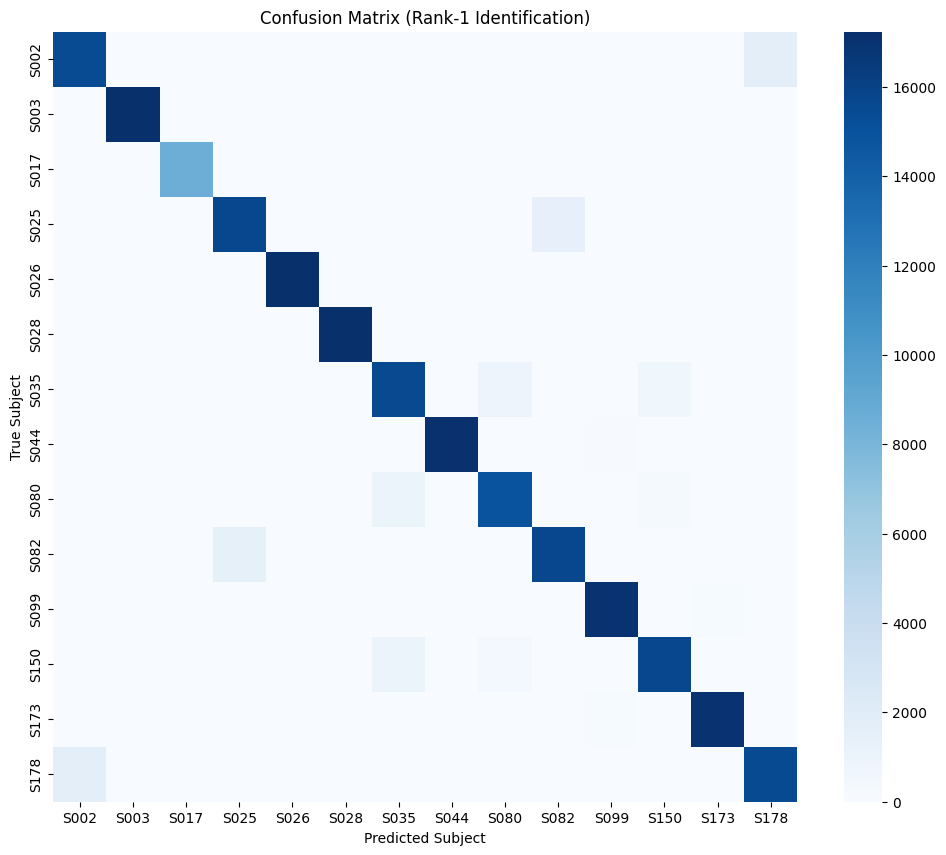

In [21]:
def plot_confusion_matrix_heatmap(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix (Rank-1 Identification)")
    plt.ylabel("True Subject")
    plt.xlabel("Predicted Subject")
    plt.show()

# 1. Fit Nearest Neighbor on the test set itself (Leave-One-Out)
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(embeddings, labels)

# 2. Predict
# For each sample, find the closest neighbor that is NOT itself
distances, indices = knn.kneighbors(embeddings, n_neighbors=2)
predicted_labels = []

for i, row_indices in enumerate(indices):
    # The closest match (index 0) is usually the sample itself. We take index 1.
    # Note: If your dataset allows duplicates, this logic is a strict approximation.
    neighbor_idx = row_indices[1]
    predicted_labels.append(labels[neighbor_idx])

# 3. Calculate Accuracy
acc = accuracy_score(labels, predicted_labels)
print(f"=======================================")
print(f"RANK-1 IDENTIFICATION ACCURACY: {acc*100:.2f}%")
print(f"=======================================")

# 4. Plot
unique_labels = np.unique(labels)
plot_confusion_matrix_heatmap(labels, predicted_labels, unique_labels)

Running t-SNE on 7000 samples...


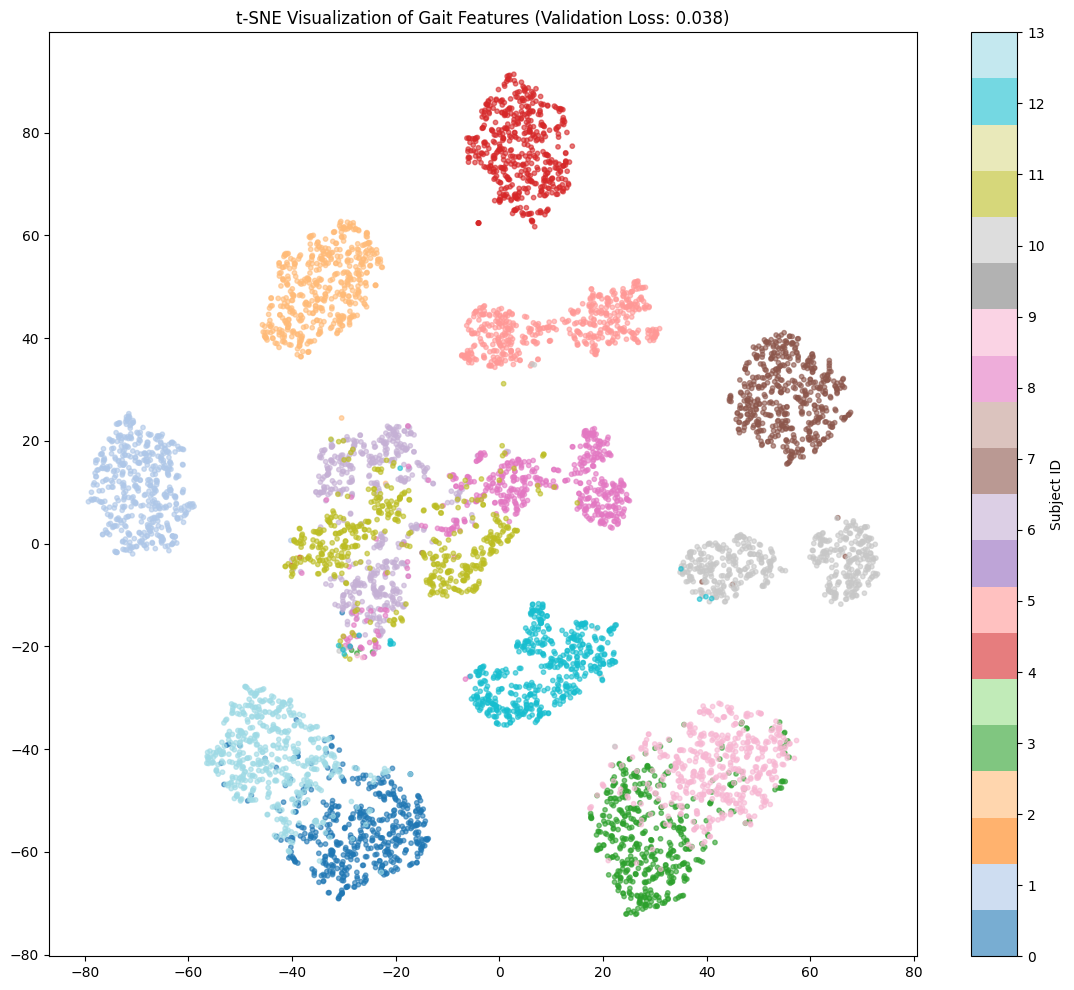

In [ ]:
# Downsample for speed (t-SNE is slow on 60k points)
# We take 500 samples per person max
indices_to_plot = []
for pid in np.unique(labels):
    idxs = np.where(labels == pid)[0]
    if len(idxs) > 500:
        idxs = np.random.choice(idxs, 500, replace=False)
    indices_to_plot.extend(idxs)

X_sample = embeddings[indices_to_plot]
y_sample = labels[indices_to_plot]

print(f"Running t-SNE on {len(X_sample)} samples...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
X_embedded = tsne.fit_transform(X_sample)

plt.figure(figsize=(14, 12))
# Map unique labels to integers for coloring
unique_y = np.unique(y_sample)
y_int = np.array([np.where(unique_y == y)[0][0] for y in y_sample])

scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_int, cmap='tab20', alpha=0.6, s=10)
temp=""#"(Validation Loss: 0.038)"
plt.title(f"t-SNE Visualization of Gait Features {temp}")
plt.colorbar(scatter, ticks=range(len(unique_y)), label='Subject ID')
plt.show()